In [1]:
import os, shutil
from keras import layers, models, optimizers
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam

In [2]:
import random
import warnings
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 21
seed_everything(seed)
warnings.filterwarnings('ignore')

In [3]:
work_dir = '../input/cassava-leaf-disease-classification/'
os.listdir(work_dir) 
train_path = '/kaggle/input/cassava-leaf-disease-classification/train_images'
data = pd.read_csv(work_dir + 'train.csv')
print(data['label'].value_counts())

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
with tf.device('/GPU:0'):
    print('Yes, there is GPU')
    
tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
Yes, there is GPU


In [5]:
import json
with open(work_dir + 'label_num_to_disease_map.json') as f:
    real_labels = json.load(f)
    real_labels = {int(k):v for k,v in real_labels.items()}
data['class_name'] = data['label'].map(real_labels)
real_labels

{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size = 0.05, random_state = 42, stratify = data['class_name'])

In [7]:
IMG_SIZE = 512
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

In [8]:
pip install cutmix-keras

Note: you may need to restart the kernel to use updated packages.


In [9]:
datagen_train = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = 'nearest',
)

datagen_test = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

In [11]:
from cutmix_keras import CutMixImageDataGenerator
train_set_1 = datagen_train.flow_from_dataframe(
    train,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = BATCH_SIZE,
)
train_set_2 = datagen_train.flow_from_dataframe(
    train,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle = True,
    batch_size = BATCH_SIZE,
)
train_generator = CutMixImageDataGenerator(
    generator1=train_set_1,
    generator2=train_set_2,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
)
test_set = datagen_test.flow_from_dataframe(
    test,
    directory=train_path,
    seed=42,
    x_col='image_id',
    y_col='class_name',
    target_size = size,
    class_mode='categorical',
    interpolation='nearest',
    shuffle=True,
    batch_size=BATCH_SIZE,    
)

Found 20327 validated image filenames belonging to 5 classes.
Found 20327 validated image filenames belonging to 5 classes.
Found 1070 validated image filenames belonging to 5 classes.


In [23]:
from tensorflow.keras.applications import EfficientNetB4
pre_weights="../input/cassava-leaf-disease-efficientnetb4/efficientnetb4_noisystudent_notop.h5/efficientnetb4_noisystudent_notop.h5"
model = Sequential()
efficientnet= EfficientNetB4(input_shape = (IMG_SIZE, IMG_SIZE, 3), weights = pre_weights, include_top = False,drop_connect_rate=0.4)
for layer in efficientnet.layers:
    layer.trainable = False
model.add(efficientnet)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(n_CLASS, activation = 'softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1792)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1792)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 8965      
Total params: 17,682,788
Trainable params: 8,965
Non-trainable params: 17,673,823
_________________________________________________________________


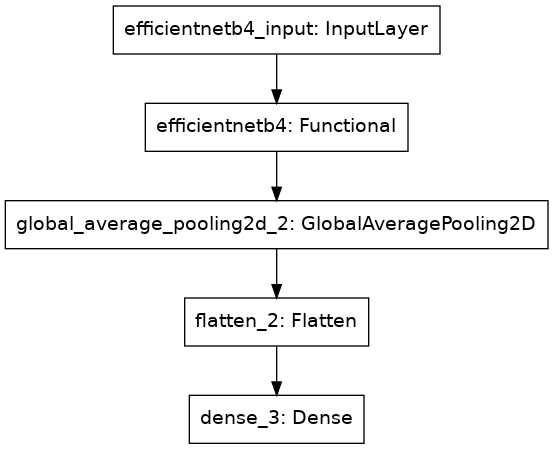

In [24]:
keras.utils.plot_model(model)

In [35]:
import tensorflow_addons as tfa
def model_fit():
    loss =tfa.losses.SigmoidFocalCrossEntropy(
        from_logits = False,
        name='sigmoid_focal_crossentropy'
    )
    model.compile(
        optimizer = Adam(learning_rate = 1e-3),
        loss = loss,
        metrics = ['categorical_accuracy']
    )
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        patience=3,
        restore_best_weights=True, 
        verbose=1,
    )
    checkpoint_cb = ModelCheckpoint(
        "Cassava_best_model1.h5",
        save_best_only=True,
        monitor='val_loss',
        mode='min',
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        mode='min',
        verbose=1,
    )
    history = model.fit_generator(
        generator=train_generator,
        validation_data=test_set,
        epochs=25,
        steps_per_epoch=train_generator.get_steps_per_epoch(),
        callbacks=[es, checkpoint_cb, reduce_lr],
    )
    model.save('Cassava_model_effnetb4_cutmix'+'.h5')  
    return history

In [36]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

from tensorflow.compat.v1.keras import backend as K
K.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



In [37]:
try:
    final_model = keras.models.load_model('Cassava_model.h5')
except Exception as e:
    with tf.device('/GPU:0'):
        results = model_fit()
    print('Train Categorical Accuracy: ', max(results.history['categorical_accuracy']))
    print('Test Categorical Accuracy: ', max(results.history['val_categorical_accuracy']))

Epoch 1/25
   7/1356 [..............................] - ETA: 41:43 - loss: 0.1427 - categorical_accuracy: 0.6544

KeyboardInterrupt: 

In [28]:
def trai_test_plot(acc, test_acc, loss, test_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Model's metrics comparisson", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(test_acc) + 1), test_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(test_loss) + 1), test_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

trai_test_plot(
    results.history['categorical_accuracy'],
    results.history['val_categorical_accuracy'],
    results.history['loss'],
    results.history['val_loss']
)

NameError: name 'results' is not defined

In [ ]:
final_model = keras.models.load_model('Cassava_model.h5')

In [ ]:
TEST_DIR = '../input/cassava-leaf-disease-classification/test_images/'
test_images = os.listdir(TEST_DIR)
predictions = []

for image in test_images:
    img = Image.open(TEST_DIR + image)
    img = img.resize(size)
    img = np.expand_dims(img, axis=0)
    predictions.extend(final_model.predict(img).argmax(axis = 1))

In [ ]:
predictions

In [ ]:
sub = pd.DataFrame({'image_id': test_images, 'label': predictions})
display(sub)
sub.to_csv('submission.csv', index = False)